In [1]:
import re
from functools import reduce
from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
from edit_distance import edit_distance
from IPython.display import display
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, average_precision_score, f1_score
from tqdm import tqdm

from datasets.functions_dataset import FunctionsDataset
%matplotlib inline

In [2]:
balanced = "_unbalanced"
# balanced = ""

In [3]:
def rep_len(path: str):
    if path.endswith(".txt"):
        graph = FunctionsDataset.parse_graph(path, return_tensor=False)
        return len(graph)
    tokens = FunctionsDataset.tokenize(path, return_tensor=False)
    return len(tokens)

In [4]:
def seq_lens(paths: list):
    with Pool() as p:
        return np.array(p.map(rep_len, paths))

In [5]:
def load_results(data_root):
    dfs = []
    for pair in tqdm(list(Path(data_root).glob(f"**/!pairs{balanced}.csv"))):
        df = pd.read_csv(str(pair), names=["f1", "f2", "clone"])
        alpha, n, p, r = pair.parts[-6:-2]
        df["alpha"] = alpha
        df["n"] = n
        df["p"] = p
        df["r"] = r
        df["set"] = str(pair.parent)
#         df["len_f1"] = seq_lens([str(pair.parent / p) for p in df["f1"]])
#         df["len_f2"] = seq_lens([str(pair.parent / p) for p in df["f2"]])
        same_base = []
        pattern = re.compile(r"\d*$")
            
        for i, row in df.iterrows():
            base1 = pattern.split(Path(Path(row.f1).stem).stem)[0]
            base2 = pattern.split(Path(Path(row.f2).stem).stem)[0]
            if base1 != base2:
                same_base.append(0)
            else:
                same_base.append(1)
        df["same_base"] = same_base
        for results in pair.parent.glob(f"!*{balanced}.csv"):
            if results.name in [f"!pairs{balanced}.csv", "!benchmark.csv"]:
                continue
            df[results.name] = pd.read_csv(str(results), names=["similarity"]).similarity
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [6]:
token_results = load_results("data/text")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1080/1080 [07:25<00:00,  2.43it/s]


In [7]:
graph_results = load_results("data/graphs")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1080/1080 [07:33<00:00,  2.38it/s]


In [40]:
# token_results["len_diff"] = (token_results["len_f1"] - token_results["len_f2"]).abs()
# graph_results["len_diff"] = (graph_results["len_f1"] - graph_results["len_f2"]).abs()

In [8]:
token_results.rename(columns={f"!lstm_epoch=17-step=17999.ckpt{balanced}.csv": "classifier",
                              f"!lstm_epoch=24-step=24324.ckpt{balanced}.csv": "encoder",
                              f"!gst{balanced}.csv": "gst"}, inplace=True)
drop_cols = [col_name for col_name in token_results.columns if "!" in col_name]
token_results.drop(columns=drop_cols, inplace=True)
token_similarity_cols = ["classifier", "encoder", "gst"]

graph_results.rename(columns={f"!gnn_epoch=10-step=1836.ckpt{balanced}.csv": "classifier",
                              f"!gnn_epoch=34-step=5704.ckpt{balanced}.csv": "encoder",
                              f"!wlk{balanced}.csv": "wlk"}, inplace=True)
drop_cols = [col_name for col_name in graph_results.columns if "!" in col_name]
graph_results.drop(columns=drop_cols, inplace=True)
graph_similarity_cols = ["classifier", "encoder", "wlk"]
groupby_cols = ["alpha", "n", "p", "r"]

In [9]:
for col_name in token_similarity_cols:
    print(col_name, ":", average_precision_score(token_results["clone"], token_results[col_name]))

classifier : 0.9507523445519757
encoder : 0.9433003376557231
gst : 0.9246948143784534


In [10]:
for col_name in graph_similarity_cols:
    print(col_name, ":", average_precision_score(graph_results["clone"], graph_results[col_name]))

classifier : 0.9417343458157895
encoder : 0.9220327476860901
wlk : 0.9226952865718876


In [11]:
pd.to_pickle(token_results, f"token_results{balanced}.pkl")
pd.to_pickle(graph_results, f"graph_results{balanced}.pkl")

In [45]:
token_results = pd.read_pickle(f"token_results{balanced}.pkl")
graph_results = pd.read_pickle(f"graph_results{balanced}.pkl")

In [12]:
def metric_by_set(results_df, method, metric_fun = average_precision_score):
    ret = results_df.groupby(groupby_cols).apply(
                    lambda sub_df: metric_fun(sub_df["clone"], sub_df[method])
                    ).to_frame().reset_index()
    ret = ret.rename(columns={0: method})
    return ret

In [13]:
def metrics_on_each_set(results_df, methods, metric_fun = average_precision_score):
    dfs = [metric_by_set(results_df, method, metric_fun) for method in methods]
    ret = reduce(lambda left, right: pd.merge(left, right, on=groupby_cols, how='inner'), dfs)
#     ret = pd.concat([ret, ret["set"].str.split("/", expand=True)[[2, 3, 4, 5]]], axis="columns")
#     ret = ret.rename(columns={2: "alpha", 3: "n", 4: "p", 5: "r"})
    # ret["alpha"], ret["n"], ret["p"], ret["r"] = 
    return ret

In [14]:
graph_metrics  = metrics_on_each_set(graph_results, graph_similarity_cols)
token_metrics = metrics_on_each_set(token_results, token_similarity_cols)

In [15]:
def metric_by_param(metrics, param: str, methods):
    std = metrics.groupby(param).std()
    table = metrics.groupby(param).mean()
    means = table[methods].values
    bold_max = np.argmax(means, axis=1)
    for m in methods:
        table[m] = table[m].map("{:.3f}".format) + " ± " + std[m].map("{:.3f}".format)
    vals = table[methods].values
    for row, col in enumerate(bold_max):
        vals[row, col] = "\textbf{" + table[methods].values[row, col] + "}"
    table[methods] = vals
    return table

In [16]:
def metric_by_all_params(metrics, methods):
    params = ["p", "n", "r", "alpha"]
    for param in params:
        display(metric_by_param(metrics, param, methods))

In [17]:
token_metrics["modality"] = "tokens"
graph_metrics["modality"] = "graphs"
all_metrics = pd.concat([token_metrics, graph_metrics])

In [18]:
vals = []
for i, row in token_metrics.iterrows():
    for m in ["gst", "classifier", "encoder"]:
        vals.append({
            "modality": "tokens",
            "alpha": row["alpha"],
            "n": row["n"],
            "p": row["p"],
            "r": row["r"],
            "method": m,
            "ap": row[m]
        })
for i, row in graph_metrics.iterrows():
    for m in ["wlk", "classifier", "encoder"]:
        vals.append({
            "modality": "graphs",
            "alpha": row["alpha"],
            "n": row["n"],
            "p": row["p"],
            "r": row["r"],
            "method": m,
            "ap": row[m]
        })
all_metrics = pd.DataFrame(vals)

In [22]:
from scipy.stats import ttest_ind_from_stats, wilcoxon

def max_wilcoxon_mask(df, param):
    statistical_max = []
    for modality, modality_group in df.groupby("modality"):
        for param_val, param_group in modality_group.groupby(param):
            best_group = None
            best_median = 0
            best_method = None
            for method, method_group in param_group.groupby("method"):
                if method_group["ap"].median() > best_median:
                    best_median = method_group["ap"].median()
                    best_group = method_group
                    best_method = method
            for method, method_group in param_group.groupby("method"):
                if best_method != method:
                    test_res = wilcoxon(best_group["ap"], method_group["ap"])
                    alpha = 0.05
                    if test_res[1] < alpha:
                        stat_max = False
                    else:
                        stat_max = True
                else:
                    stat_max = True
                statistical_max.append({
                    param: param_val,
                    "modality": modality,
                    "method": method,
                    "stat_max": stat_max
                })
    return pd.DataFrame(statistical_max)

def max_mask(df, param, separate):
    statistical_max = []
    for separation_name, group in df.groupby(separate):
        for row_name, row_group in group.groupby(param):
            idx_max = row_group["mean"].idxmax()
            max_mean, max_std, max_count = row_group.loc[idx_max][["mean", "std", "count"]]
            for idx, row in row_group.iterrows():
                t_check = ttest_ind_from_stats(max_mean, max_std * 0.915, max_count * 10,
                                               row["mean"], row["std"] * 0.915, row["count"] * 10)
                alpha = 0.1
#                 print(t_check)
                if(t_check[1] < alpha):
                    stat_max = False
                else:
                    stat_max = True
#                 if idx == idx_max:
#                     stat_max = True
#                 else:
#                     stat_max = False
                statistical_max.append({
                    "index": idx,
                    "stat_max": stat_max
                })
    return pd.DataFrame(statistical_max).set_index("index")

In [23]:
def aps(all_metrics, param):
    aps_by_param = all_metrics.groupby([param, "modality", "method"], as_index=False).ap.agg({"median": "median", "std": "std", "count": "count"})
    
#     m = max_mask(aps_by_param, param, "modality")
#     aps_by_param = aps_by_param.join(m)
    
    m = max_wilcoxon_mask(all_metrics, param)
    aps_by_param = aps_by_param.merge(m, on=[param, "modality", "method"])
#     aps_by_param["std"] *= 0.915
    aps_by_param["ap"] = aps_by_param["median"].map("{:.3f}".format) + " ± " + aps_by_param["std"].map("{:.3f}".format)
    def format_str(row):
        if row["stat_max"]:
            return r"\textbf{" + row["ap"] + "}"
        return row["ap"]
    aps_by_param["ap"] = aps_by_param.apply(format_str, axis="columns")
    return aps_by_param.pivot(index=param, columns=["modality","method"], values="ap")

In [24]:
def prefix_format(param):
    return "\\begin{table}\n\\caption{}\n\\label{table:" + "results_" + param + "}\n\\centering\n"

suffix = "\\end{table}"

for param in ["p", "alpha", "r", "n"]:
    print(f"\n%%%%% {param} %%%%%\n\n")
    prefix = prefix_format(param)
    table = prefix + aps(all_metrics, param).to_latex(escape=False) + suffix
    print(table.replace("lllllll", "l|rrr|rrr"))


%%%%% p %%%%%


\begin{table}
\caption{}
\label{table:results_p}
\centering
\begin{tabular}{l|rrr|rrr}
\toprule
modality & \multicolumn{3}{l}{graphs} & \multicolumn{3}{l}{tokens} \\
method &              classifier &        encoder &            wlk &              classifier &        encoder &            gst \\
p      &                         &                &                &                         &                &                \\
\midrule
p=0.05 &  \textbf{0.962 ± 0.047} &  0.950 ± 0.060 &  0.948 ± 0.052 &  \textbf{0.967 ± 0.042} &  0.960 ± 0.052 &  0.951 ± 0.046 \\
p=0.1  &  \textbf{0.956 ± 0.038} &  0.942 ± 0.043 &  0.942 ± 0.053 &  \textbf{0.968 ± 0.033} &  0.962 ± 0.040 &  0.941 ± 0.044 \\
p=0.25 &  \textbf{0.958 ± 0.040} &  0.923 ± 0.046 &  0.923 ± 0.050 &  \textbf{0.962 ± 0.032} &  0.956 ± 0.039 &  0.915 ± 0.046 \\
\bottomrule
\end{tabular}
\end{table}

%%%%% alpha %%%%%


\begin{table}
\caption{}
\label{table:results_alpha}
\centering
\begin{tabular}{l|rrr|rrr}
\toprule

/tmp/ipykernel_507284/2726546668.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = prefix + aps(all_metrics, param).to_latex(escape=False) + suffix
/tmp/ipykernel_507284/2726546668.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = prefix + aps(all_metrics, param).to_latex(escape=False) + suffix
/tmp/ipykernel_507284/2726546668.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` 

In [82]:
def all_metric_by_param(metrics, param: str, methods):
    std = metrics.groupby(param).std()
    table = metrics.groupby(param).mean()
    means = table[methods].values
    bold_max = np.argmax(means, axis=1)
    for m in methods:
        table[m] = table[m].map("{:.3f}".format) + " ± " + std[m].map("{:.3f}".format)
    vals = table[methods].values
    for row, col in enumerate(bold_max):
        vals[row, col] = "\textbf{" + table[methods].values[row, col] + "}"
    table[methods] = vals
    return table

,alpha,n,p,r,classifier,encoder,gst,modality,wlk
0,alpha=1.0,n=1000,p=0.05,r=0.1,0.972963,0.933783,0.953410,tokens,NaN
1,alpha=1.0,n=1000,p=0.05,r=0.2,0.963758,0.957740,0.956305,tokens,NaN
2,alpha=1.0,n=1000,p=0.1,r=0.1,0.916806,0.906320,0.907884,tokens,NaN
3,alpha=1.0,n=1000,p=0.1,r=0.2,0.992022,0.993386,0.993947,tokens,NaN
4,alpha=1.0,n=1000,p=0.25,r=0.1,0.985527,0.990380,0.972858,tokens,NaN
...,...,...,...,...,...,...,...,...,...
79,alpha=2.0,n=500,p=0.05,r=0.2,0.987421,0.994967,NaN,graphs,0.995577
80,alpha=2.0,n=500,p=0.1,r=0.1,0.986146,0.958328,NaN,graphs,0.953817
81,alpha=2.0,n=500,p=0.1,r=0.2,0.970912,0.977195,NaN,graphs,0.966396
82,alpha=2.0,n=500,p=0.25,r=0.1,0.992470,0.991222,NaN,graphs,0.946094


In [79]:
metric_by_all_params(token_metrics, token_similarity_cols)
metric_by_all_params(graph_metrics,  graph_similarity_cols)

,classifier,encoder,gst
p,,,
p=0.05,0.952 ± 0.063,0.952 ± 0.057,\textbf{0.953 ± 0.062}
p=0.1,\textbf{0.957 ± 0.048},0.948 ± 0.069,0.952 ± 0.046
p=0.25,\textbf{0.957 ± 0.055},0.956 ± 0.055,0.907 ± 0.094


,classifier,encoder,gst
n,,,
n=1000,0.968 ± 0.038,\textbf{0.969 ± 0.038},0.953 ± 0.051
n=200,\textbf{0.950 ± 0.051},0.947 ± 0.047,0.931 ± 0.076
n=50,\textbf{0.918 ± 0.077},0.913 ± 0.091,0.898 ± 0.098
n=500,\textbf{0.984 ± 0.014},0.977 ± 0.020,0.967 ± 0.034


,classifier,encoder,gst
r,,,
r=0.1,\textbf{0.953 ± 0.053},0.948 ± 0.052,0.938 ± 0.076
r=0.2,\textbf{0.955 ± 0.059},0.951 ± 0.070,0.932 ± 0.076
r=0.3,0.959 ± 0.055,\textbf{0.963 ± 0.053},0.951 ± 0.051


,classifier,encoder,gst
alpha,,,
alpha=1.0,\textbf{0.944 ± 0.039},0.941 ± 0.044,0.920 ± 0.065
alpha=1.5,\textbf{0.953 ± 0.069},0.951 ± 0.078,0.944 ± 0.078
alpha=2.0,\textbf{0.968 ± 0.045},0.964 ± 0.041,0.944 ± 0.071


,classifier,encoder,wlk
p,,,
p=0.05,0.938 ± 0.071,0.933 ± 0.074,\textbf{0.944 ± 0.071}
p=0.1,\textbf{0.956 ± 0.054},0.941 ± 0.053,0.949 ± 0.051
p=0.25,\textbf{0.945 ± 0.069},0.907 ± 0.101,0.908 ± 0.107


,classifier,encoder,wlk
n,,,
n=1000,\textbf{0.974 ± 0.027},0.960 ± 0.044,0.966 ± 0.040
n=200,\textbf{0.943 ± 0.053},0.931 ± 0.051,0.923 ± 0.092
n=50,\textbf{0.889 ± 0.090},0.865 ± 0.116,0.884 ± 0.105
n=500,\textbf{0.979 ± 0.017},0.953 ± 0.045,0.962 ± 0.036


,classifier,encoder,wlk
r,,,
r=0.1,\textbf{0.947 ± 0.061},0.929 ± 0.084,0.936 ± 0.085
r=0.2,\textbf{0.944 ± 0.075},0.924 ± 0.082,0.930 ± 0.079
r=0.3,\textbf{0.952 ± 0.043},0.932 ± 0.055,0.940 ± 0.080


,classifier,encoder,wlk
alpha,,,
alpha=1.0,\textbf{0.934 ± 0.052},0.903 ± 0.068,0.918 ± 0.053
alpha=1.5,\textbf{0.947 ± 0.076},0.937 ± 0.073,0.938 ± 0.094
alpha=2.0,\textbf{0.958 ± 0.057},0.936 ± 0.095,0.944 ± 0.083


In [80]:
param = "p"
def prefix_format(method, param):
    return "\\begin{table}\n\\caption{}\n\\label{table:" + method + "_results_" + param + "}\n\\centering\n"

suffix = "\\end{table}"

for param in ["p", "alpha", "r", "n"]:
    print(f"\n%%%%% {param} %%%%%\n\n")
    prefix = prefix_format("tokens", param)
    table = prefix + metric_by_param(token_metrics, param, token_similarity_cols).to_latex(escape=False) + suffix
    print(table.replace("llll", "l|rrr"))
    print("\n\n")
    prefix = prefix_format("graphs", param)
    table = prefix + metric_by_param(graph_metrics, param, graph_similarity_cols).to_latex(escape=False) + suffix
    print(table.replace("llll", "l|rrr"))


%%%%% p %%%%%


\begin{table}
\caption{}
\label{table:tokens_results_p}
\centering
\begin{tabular}{l|rrr}
\toprule
{} &              classifier &        encoder &                     gst \\
p      &                         &                &                         \\
\midrule
p=0.05 &           0.952 ± 0.063 &  0.952 ± 0.057 &  \textbf{0.953 ± 0.062} \\
p=0.1  &  \textbf{0.957 ± 0.048} &  0.948 ± 0.069 &           0.952 ± 0.046 \\
p=0.25 &  \textbf{0.957 ± 0.055} &  0.956 ± 0.055 &           0.907 ± 0.094 \\
\bottomrule
\end{tabular}
\end{table}



\begin{table}
\caption{}
\label{table:graphs_results_p}
\centering
\begin{tabular}{l|rrr}
\toprule
{} &              classifier &        encoder &                     wlk \\
p      &                         &                &                         \\
\midrule
p=0.05 &           0.938 ± 0.071 &  0.933 ± 0.074 &  \textbf{0.944 ± 0.071} \\
p=0.1  &  \textbf{0.956 ± 0.054} &  0.941 ± 0.053 &           0.949 ± 0.051 \\
p=0.25 &  \textbf{0.945

/tmp/ipykernel_121553/2061807076.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = prefix + metric_by_param(token_metrics, param, token_similarity_cols).to_latex(escape=False) + suffix
/tmp/ipykernel_121553/2061807076.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = prefix + metric_by_param(graph_metrics, param, graph_similarity_cols).to_latex(escape=False) + suffix
/tmp/ipykernel_121553/2061807076.py:10: FutureWarning: In future versions `DataFrame.t

In [30]:
def eer_thr(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=1)
    fnr = 1 - tpr
    return threshold[np.nanargmin(np.absolute((fnr - fpr)))]


In [31]:
def eer_thr_by_set(results_df, method):
    ret = results_df.groupby("set").apply(lambda sub_df: eer_thr(sub_df["clone"], sub_df[method])).to_frame().reset_index()
    ret = ret.rename(columns={0: method})
    return ret

def eer_thr_all(results_df, method):
    return eer_thr(results_df["clone"], results_df[method])

In [32]:
eer_thr_all(token_results, "gst")

0.1616915422885572

In [33]:
def precision(results_df, methods):
    for m in methods:
        print(m, f1_score(
            results_df["clone"],
            results_df[m] > eer_thr_all(results_df, m)
            ))

precision(token_results, token_similarity_cols)
precision(graph_results, graph_similarity_cols)

classifier 0.615779397987862
encoder 0.5896612492657138
gst 0.5285121180937511
classifier 0.5623531195512091
encoder 0.5238357723288111
wlk 0.512406796235179


In [34]:
def plot_roc(results_df, method):
    fpr, tpr, _ = roc_curve(results_df["clone"], results_df[method])
    return sns.lineplot(x=fpr, y=tpr)


<AxesSubplot:>

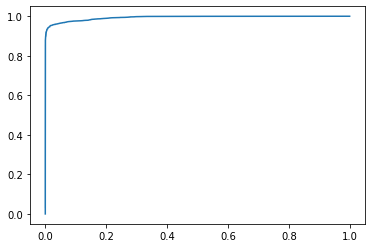

In [35]:
plot_roc(token_results, "encoder")

In [36]:
def accuracy_by_same_base(results_df, methods):
    for m in methods:
        eer_thr = eer_thr_all(results_df, m)
        sub_df = results_df[results_df["clone"] == 1]
        sub_df1 = sub_df[sub_df["same_base"] == 1]
        sub_df2 = sub_df[sub_df["same_base"] == 0]
        print(m, "same_base", accuracy_score(
            sub_df1["clone"],
            sub_df1[m] > eer_thr
            ))
        print(m, "not same_base", accuracy_score(
            sub_df2["clone"],
            sub_df2[m] > eer_thr
            ))


In [37]:
accuracy_by_same_base(token_results, token_similarity_cols)
accuracy_by_same_base(graph_results, graph_similarity_cols)

classifier same_base 0.9966159052453468
classifier not same_base 0.44157303370786516
encoder same_base 0.990321489001692
encoder not same_base 0.47752808988764045
gst same_base 0.9834179357021997
gst not same_base 0.40898876404494383
classifier same_base 0.9906042109594678
classifier not same_base 0.42701525054466233
encoder same_base 0.9827172347575612
encoder not same_base 0.43681917211328974
wlk same_base 0.987723750085728
wlk not same_base 0.29411764705882354


<AxesSubplot:xlabel='len_diff', ylabel='classifier'>

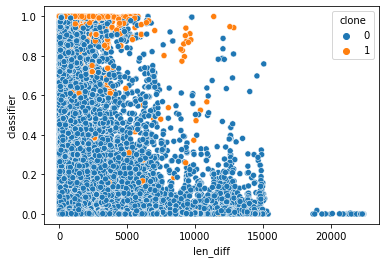

In [38]:
sns.scatterplot(x=token_results["len_diff"], y=token_results["classifier"], hue=token_results["clone"])

In [21]:
sim = graph_results["wlk"].values
y = graph_results["clone"].values

In [22]:
def best_f1(sim, y):
    best_f = 0
    for thr in tqdm(np.linspace(np.min(sim), np.max(sim), 1_000)):
        pred = sim > thr
        f = f1_score(y, pred)
        if f > best_f:
            best_f = f
    return best_f

best_f1(sim, y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.38it/s]


0.9166334793574937

In [237]:
all_metrics.query("r == 'r=0.3'")[["alpha", "n", "p"]].value_counts()

alpha      n       p     
alpha=1.0  n=1000  p=0.05    6
                   p=0.1     6
alpha=1.5  n=50    p=0.25    6
           n=500   p=0.05    6
                   p=0.1     6
                   p=0.25    6
alpha=2.0  n=1000  p=0.05    6
                   p=0.1     6
                   p=0.25    6
           n=200   p=0.05    6
                   p=0.1     6
                   p=0.25    6
           n=50    p=0.05    6
                   p=0.1     6
                   p=0.25    6
           n=500   p=0.05    6
                   p=0.1     6
alpha=1.5  n=50    p=0.1     6
                   p=0.05    6
           n=200   p=0.25    6
alpha=1.0  n=50    p=0.25    6
           n=1000  p=0.25    6
           n=200   p=0.05    6
                   p=0.1     6
                   p=0.25    6
           n=50    p=0.05    6
                   p=0.1     6
           n=500   p=0.05    6
alpha=1.5  n=200   p=0.1     6
alpha=1.0  n=500   p=0.1     6
                   p=0.25    6
alpha=1.5  n=

In [252]:
aps = []
for group_name, group in token_results.groupby("set"):
    if "/10" not in group_name:
        continue
    aps.append(average_precision_score(group["clone"], group["gst"]))
print(np.mean(aps), np.std(aps), len(aps))

0.8595055863349276 0.09468755670992512 108


In [254]:
0.08666978305178732 / 0.09468755670992512

0.9153238932682548